<a href="https://colab.research.google.com/github/Olesya-Mo/Ideal_learner_model/blob/main/Sequence_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import the necessary packages

import random
import math
import numpy as np
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
#ISSUES:
#store the sequences in the dict to access later when using formulas
#random.seed does not work for some reason
#random.sample or random.choice?
#

In [ ]:
#define the main variables: number of sequences, subjects, trials, locations, probabilities of locations appearing,
#levels of complexity. 

nseq = 10 #number of sequences
ntrial = 10 #number of trials in each sequence
nsubj = 40 #number of subjects - might be useful later
locations = [1,2,3,4] #locations/boxes

seq = np.empty([nseq, ntrial], dtype=int) #creating an empty array to fill it with sequences
weights = np.empty([nseq,len(locations)]) #creating weights for different sequences

#the percentage of times the target would appear in the "main" box
seq_complexity = OrderedDict({'easy': [1, 0, 0, 0]
                     , 'moderate_1':  [0.8, 0.2/3, 0.2/3, 0.2/3]
                     , 'moderate_2':  [0.6, 0.4/3, 0.4/3, 0.4/3]
                     , 'difficult':   [0.25, 0.25, 0.25, 0.25]})

#seq_order = random.choices(list(seq_complexity.keys()), k=nseq, weights=[0.2,0.3,0.3,0.2]) #randomizing the order of the sequences to account for fatigue and exclude influence of toys
#seq_order = random.choices(sequences, k=nseq, weights=[0.2,0.3,0.3,0.2])
#sequences = ['easy','easy','moderate_1','moderate_1','moderate_1','moderate_2','moderate_2','moderate_2','difficult','difficult']


In [ ]:
#create a function that creates sequences. The order of sequences, the locations are pseudorandomized.
#sequences_list variable makes it so that there are enough sequences of each level of complexity -
#as we are mostly interested in moderate level, there are more of those, and less of easy and difficult sequences 

def create_sequences():
    random.seed(12)
    sequences_list = ['easy', 'easy', 'moderate_1', 'moderate_1', 'moderate_1', 
                      'moderate_2', 'moderate_2', 'moderate_2', 'difficult', 'difficult']
    random.shuffle(sequences_list)
    for i in range(nseq):
        #sequences = {}
        sequences = []
        seq_complexity_i = seq_complexity.get(sequences_list[i])
        loc_prob = seq_complexity_i / np.sum(seq_complexity_i)
        np.random.shuffle(locations)
        seq[i] = random.choices(locations, k=ntrial,weights=loc_prob)
        #sequences.__setitem__('seq[i]','sequences_list[i]') 
        sequences.append({'seq': seq,'complexity_level': sequences_list[i]})
    return seq, sequences

#The create_sequences function is defined to generate the sequences of target locations for each trial of each sequence. 
#The function first shuffles a list of sequence complexity levels, then for each sequence, 
#it selects a complexity level from the shuffled list, calculates the probability of the target 
#appearing in each location based on the selected complexity level, shuffles the location list, 
#and uses the random.choices function to randomly select a location for each trial of the sequence 
#based on the calculated location probabilities. 
#The generated sequences are stored in the seq array.


In [ ]:
#with random.sample - if we need not true probabilities but just the amount of times the target appears? 
#the plots will look more "diverse" because of that - otherwise, random.choices adheres to the probabilities,
#so it really takes 80% _probability_, not 80% of _the times_ the target appears

def create_sequences():
    random.seed(12)
    sequences_list = ['easy', 'easy', 'moderate_1', 'moderate_1', 'moderate_1', 'moderate_2', 'moderate_2', 'moderate_2', 'difficult', 'difficult']
    random.shuffle(sequences_list)
    for i in range(nseq):
        seq_complexity_i = seq_complexity.get(sequences_list[i])
        loc_prob = seq_complexity_i / np.sum(seq_complexity_i)
        np.random.shuffle(locations)
        seq[i] = random.sample(locations*int(ntrial*np.sum(seq_complexity_i)),ntrial)
    return seq



In [ ]:
#can not make it store the level of complexity and a corresponding array!
#so now it is not clear what level of complexity is where because it is all shuffled!


create_sequences()

'moderate_2'

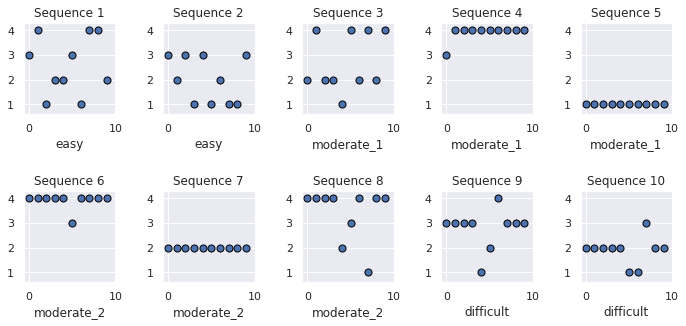

In [ ]:
#create a figure with 10 subplots to look at the sequences
sns.set()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

#flatten the axes array so that we can iterate over it easily
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.scatter(range(len(seq[i])), seq[i], s=50, c='b', marker='o', edgecolors='black')
    ax.set_title("Sequence {}".format(i+1))
    ax.set_xlabel(sequences[i]) #NOT CORRRECT
    ax.set_ylim(0.6,4.3)
    ax.set_xlim(-0.6, 10)

plt.tight_layout(pad=2)
plt.show()


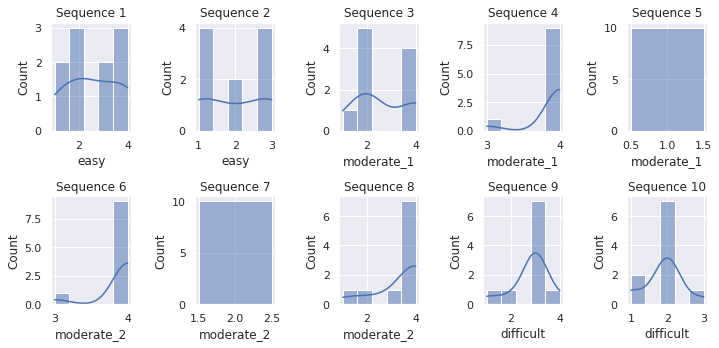

In [ ]:
#create a figure with 10 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

#flatten the axes array so that we can iterate over it easily
axes = axes.ravel()

#iterate over the data arrays and plot their distributions in the corresponding subplot
for i, ax in enumerate(axes):
    sns.histplot(seq[i], kde=True, ax=ax)
    ax.set_title("Sequence {}".format(i+1))
    ax.set_xlabel(sequences[i])

plt.tight_layout()
plt.show()
